# Practice Activity: Recurrent Neural Networks

## Predicting House Property Sales

## Data:
https://www.kaggle.com/datasets/htagholdings/property-salesLinks 

## Assignment Specs

- Implement at least one recurrent neural network model (e.g. SimpleRNN, LSTM, etc.) with these data to predict Sales.
    - Remember that train-testing works a little differently for time series data (i.e. it should NOT be random)
- A secondary goal of this assignment is to explore this very different, temporal prediction task.
    - Experiment with at least 3 different train-test splits
    - Experiment with at least 3 different values for the amount of history to include in the model (e.g. one time step, two, three, etc.). The data preprocessing for this may vary by the type of RNN used.
- Plot your results! Raw data with predictions...


### Importing Libraries

In [1]:
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN, LSTM
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import math
import matplotlib.pyplot as plt
from plotnine import ggplot, geom_point, geom_smooth, aes, stat_smooth, geom_line, xlim, ylim

In [2]:
def create_dataset_vars(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
      a = dataset[i:(i+look_back), :]
      dataX.append(a)
      dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

# Analyzing Only Houses  

### 80% Training Test Split with 2 Step History

In [25]:
data_url = "data/ma_lga_12345.csv"
house_data = pd.read_csv(data_url)
houses = house_data[house_data['type'] == 'house']
units = house_data[house_data['type'] == 'unit']

house_data2 = houses
unit_data2 = units

house_data2 = house_data2.drop(["saledate","type"], axis = 1)
unit_data2 = unit_data2.drop(["saledate","type"], axis = 1)


# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
house_data2 = scaler.fit_transform(house_data2)
unit_data2 = scaler.fit_transform(unit_data2)

train_size = int(len(house_data2) * 0.8)
test_size = len(house_data2) - train_size
train, test = house_data2[0:train_size], house_data2[train_size:len(house_data2)]
print(len(train), len(test))



160 40
160 40


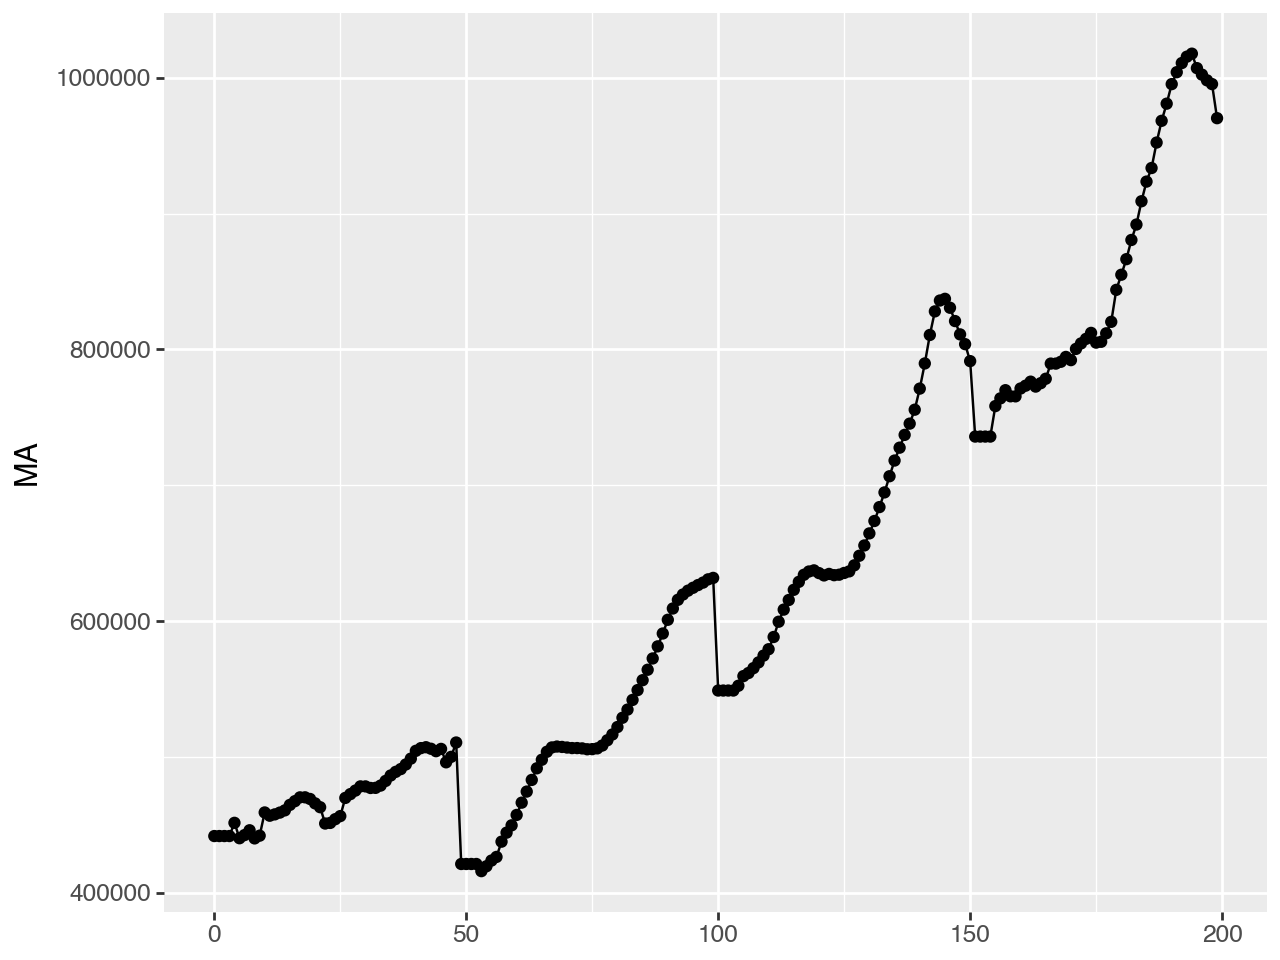

In [26]:
(ggplot(houses, aes(range(len(houses)), "MA"))
 + geom_point()
 + geom_line())

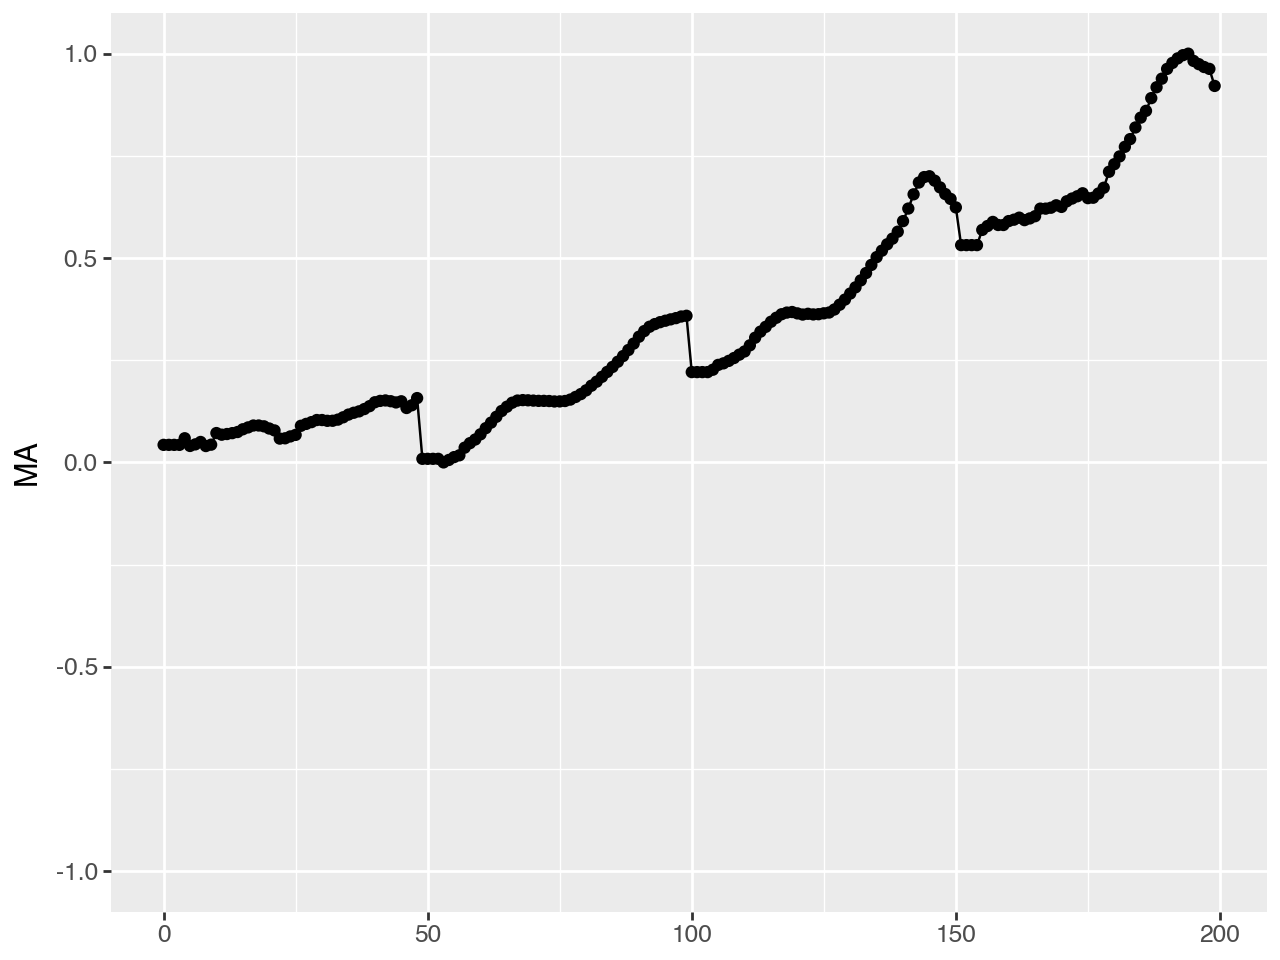

In [27]:
house_data3 = pd.DataFrame(house_data2)
house_data3.columns = ["MA", "bedrooms"]
(ggplot(house_data3, aes(range(len(house_data3)), "MA"))
 + geom_point()
 + geom_line()
 + ylim(-1, 1))

In [28]:
# reshape into X=t and Y=t+1
look_back = 2
trainX, trainY = create_dataset_vars(train, look_back)
testX, testY = create_dataset_vars(test, look_back)

In [29]:
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]*trainX.shape[2]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]*testX.shape[2]))



In [30]:
# create and fit the LSTM network
model = Sequential()
model.add(SimpleRNN(4, input_shape=(1, look_back*train.shape[1])))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=0)

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.


In [31]:
# Make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

# Add one dummy column 
trainPredict = np.hstack([trainPredict, np.zeros((trainPredict.shape[0], 1))])
testPredict = np.hstack([testPredict, np.zeros((testPredict.shape[0], 1))])

# Invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
testPredict = scaler.inverse_transform(testPredict)

# Prepare actual Y values with one dummy column
trainY2 = np.hstack([trainY.reshape(-1, 1), np.zeros((len(trainY), 1))])
testY2 = np.hstack([testY.reshape(-1, 1), np.zeros((len(testY), 1))])

# Invert actual Y values
trainY2 = scaler.inverse_transform(trainY2)
testY2 = scaler.inverse_transform(testY2)

# Calculate and print RMSE
trainScore = np.sqrt(mean_squared_error(trainY2[:, 0], trainPredict[:, 0]))
print('Train Score: %.2f RMSE' % trainScore)

testScore = np.sqrt(mean_squared_error(testY2[:, 0], testPredict[:, 0]))
print('Test Score: %.2f RMSE' % testScore)


1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


Train Score: 7429.83 RMSE
Test Score: 16880.35 RMSE
Train Score: 7429.83 RMSE
Test Score: 16880.35 RMSE


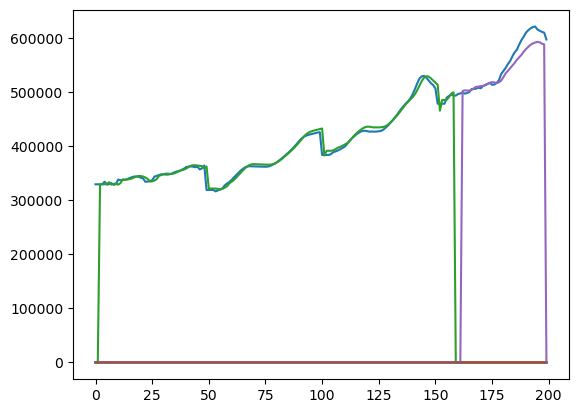

In [32]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(house_data2)
#trainPredictPlot[:, :] = np.nan
trainPredictPlot[:, :] = 0
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = np.empty_like(house_data2)
#testPredictPlot[:, :] = np.nan
testPredictPlot[:, :] = 0
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(house_data2)-1, :] = testPredict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(house_data2))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

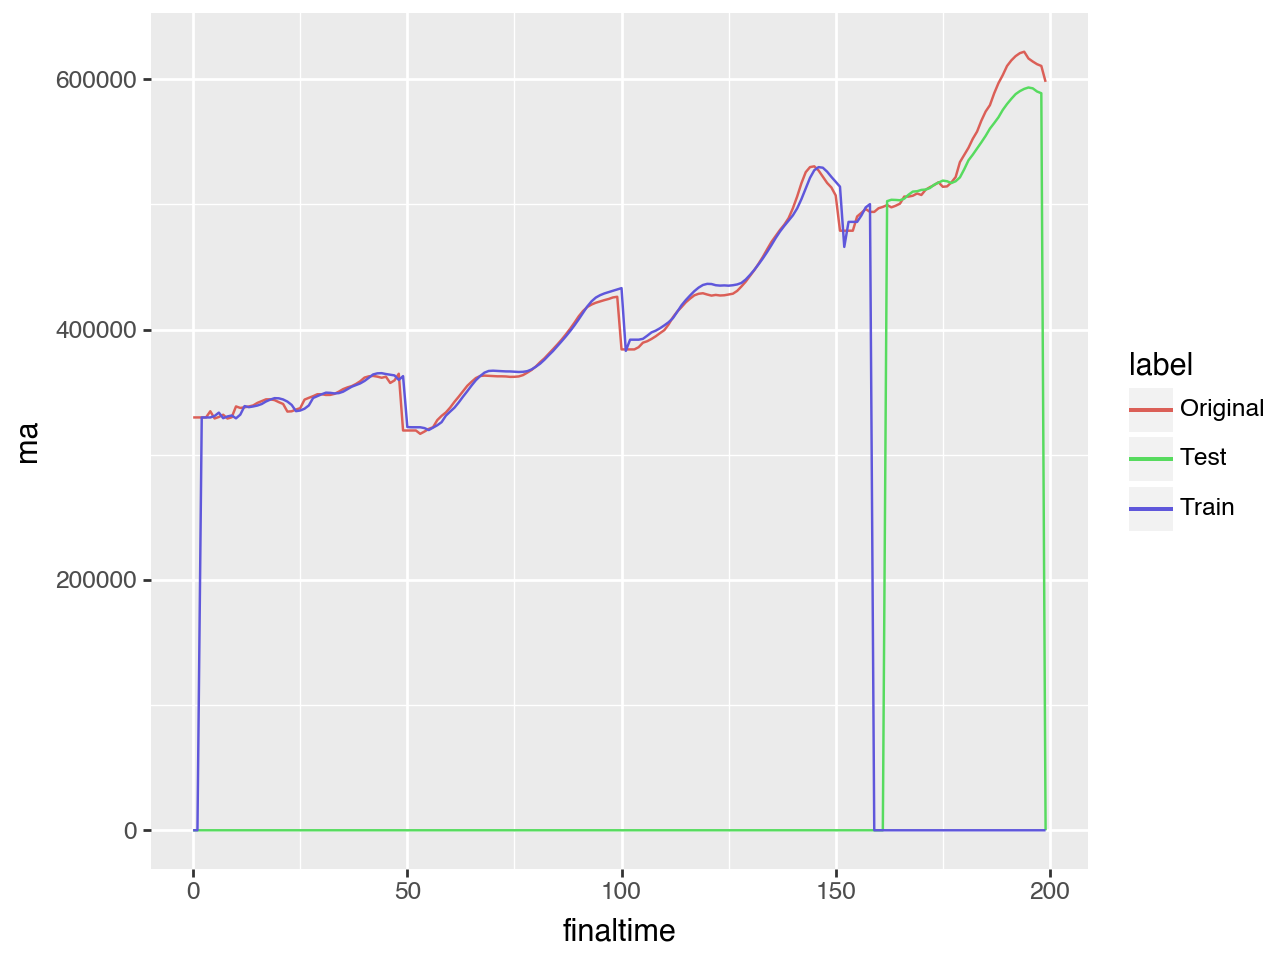

In [33]:
finalma = np.append(scaler.inverse_transform(house_data2)[:,0].flatten(), trainPredictPlot[:,0].flatten())
finalma = np.append(finalma, testPredictPlot[:,0].flatten())

finallabels = np.append(["Original"]*len(trainPredictPlot), ["Train"]*len(trainPredictPlot))
finallabels = np.append(finallabels, ["Test"]*len(testPredictPlot))

finaltime = np.append(range(len(trainPredictPlot)), range(len(trainPredictPlot)))
finaltime = np.append(finaltime, range(len(testPredictPlot)))

results = pd.DataFrame(data =
    {'timeindex': finaltime,
    'ma': finalma,
    'label': finallabels}
)

(ggplot(results, aes("finaltime", "ma", color = "label"))
 + geom_line())


### 90% Training Test Split with 3 Step Back History

In [34]:
train_size = int(len(house_data2) * 0.9)
test_size = len(house_data2) - train_size
train, test = house_data2[0:train_size], house_data2[train_size:len(house_data2)]
print(len(train), len(test))


180 20
180 20


In [35]:
# reshape into X=t and Y=t+1
look_back = 3
trainX, trainY = create_dataset_vars(train, look_back)
testX, testY = create_dataset_vars(test, look_back)

trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]*trainX.shape[2]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]*testX.shape[2]))

# create and fit the LSTM network
model = Sequential()
model.add(SimpleRNN(4, input_shape=(1, look_back*train.shape[1])))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=0)

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.


In [36]:
# Make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

# Add one dummy column 
trainPredict = np.hstack([trainPredict, np.zeros((trainPredict.shape[0], 1))])
testPredict = np.hstack([testPredict, np.zeros((testPredict.shape[0], 1))])

# Invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
testPredict = scaler.inverse_transform(testPredict)

# Prepare actual Y values with one dummy column
trainY2 = np.hstack([trainY.reshape(-1, 1), np.zeros((len(trainY), 1))])
testY2 = np.hstack([testY.reshape(-1, 1), np.zeros((len(testY), 1))])

# Invert actual Y values
trainY2 = scaler.inverse_transform(trainY2)
testY2 = scaler.inverse_transform(testY2)

# Calculate and print RMSE
trainScore = np.sqrt(mean_squared_error(trainY2[:, 0], trainPredict[:, 0]))
print('Train Score: %.2f RMSE' % trainScore)

testScore = np.sqrt(mean_squared_error(testY2[:, 0], testPredict[:, 0]))
print('Test Score: %.2f RMSE' % testScore)



1/6 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Train Score: 6455.09 RMSE
Test Score: 22994.58 RMSE
Train Score: 6455.09 RMSE
Test Score: 22994.58 RMSE


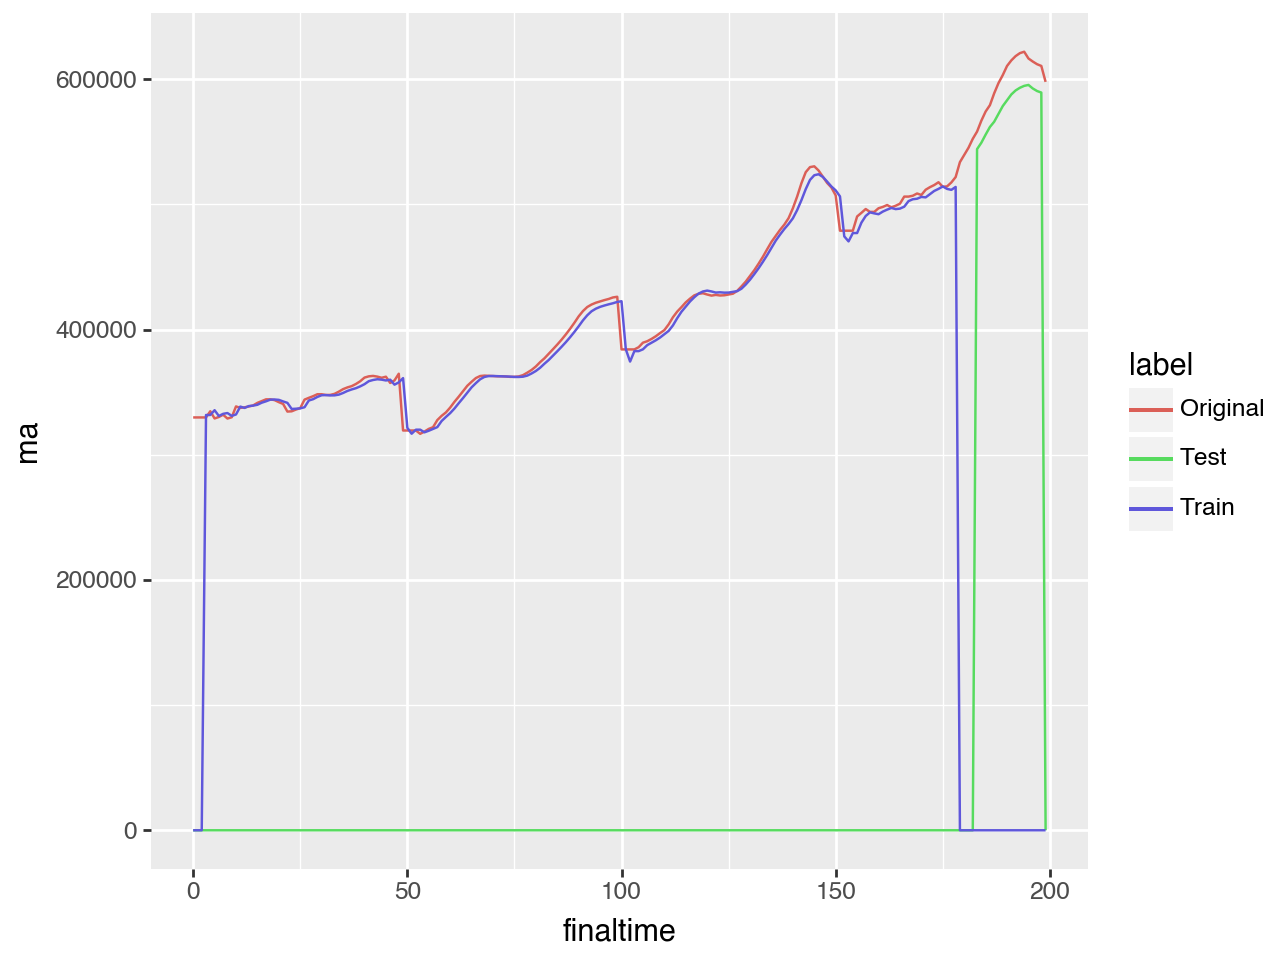

In [39]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(house_data2)
#trainPredictPlot[:, :] = np.nan
trainPredictPlot[:, :] = 0
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = np.empty_like(house_data2)
#testPredictPlot[:, :] = np.nan
testPredictPlot[:, :] = 0
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(house_data2)-1, :] = testPredict
# plot baseline and predictions
# plt.plot(scaler.inverse_transform(house_data2))
# plt.plot(trainPredictPlot)
# plt.plot(testPredictPlot)
# plt.show()


finalma = np.append(scaler.inverse_transform(house_data2)[:,0].flatten(), trainPredictPlot[:,0].flatten())
finalma = np.append(finalma, testPredictPlot[:,0].flatten())

finallabels = np.append(["Original"]*len(trainPredictPlot), ["Train"]*len(trainPredictPlot))
finallabels = np.append(finallabels, ["Test"]*len(testPredictPlot))

finaltime = np.append(range(len(trainPredictPlot)), range(len(trainPredictPlot)))
finaltime = np.append(finaltime, range(len(testPredictPlot)))

results = pd.DataFrame(data =
    {'timeindex': finaltime,
    'ma': finalma,
    'label': finallabels}
)

(ggplot(results, aes("finaltime", "ma", color = "label"))
 + geom_line())


#

In [40]:
train_size = int(len(house_data2) * 0.75)
test_size = len(house_data2) - train_size
train, test = house_data2[0:train_size], house_data2[train_size:len(house_data2)]
print(len(train), len(test))


150 50
150 50


In [41]:
# reshape into X=t and Y=t+1
look_back = 1
trainX, trainY = create_dataset_vars(train, look_back)
testX, testY = create_dataset_vars(test, look_back)

trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]*trainX.shape[2]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]*testX.shape[2]))

# create and fit the LSTM network
model = Sequential()
model.add(SimpleRNN(4, input_shape=(1, look_back*train.shape[1])))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=0)

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.


In [42]:
# Make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

# Add one dummy column 
trainPredict = np.hstack([trainPredict, np.zeros((trainPredict.shape[0], 1))])
testPredict = np.hstack([testPredict, np.zeros((testPredict.shape[0], 1))])

# Invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
testPredict = scaler.inverse_transform(testPredict)

# Prepare actual Y values with one dummy column
trainY2 = np.hstack([trainY.reshape(-1, 1), np.zeros((len(trainY), 1))])
testY2 = np.hstack([testY.reshape(-1, 1), np.zeros((len(testY), 1))])

# Invert actual Y values
trainY2 = scaler.inverse_transform(trainY2)
testY2 = scaler.inverse_transform(testY2)

# Calculate and print RMSE
trainScore = np.sqrt(mean_squared_error(trainY2[:, 0], trainPredict[:, 0]))
print('Train Score: %.2f RMSE' % trainScore)

testScore = np.sqrt(mean_squared_error(testY2[:, 0], testPredict[:, 0]))
print('Test Score: %.2f RMSE' % testScore)



1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step 

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


Train Score: 6140.44 RMSE
Test Score: 10586.79 RMSE
Train Score: 6140.44 RMSE
Test Score: 10586.79 RMSE


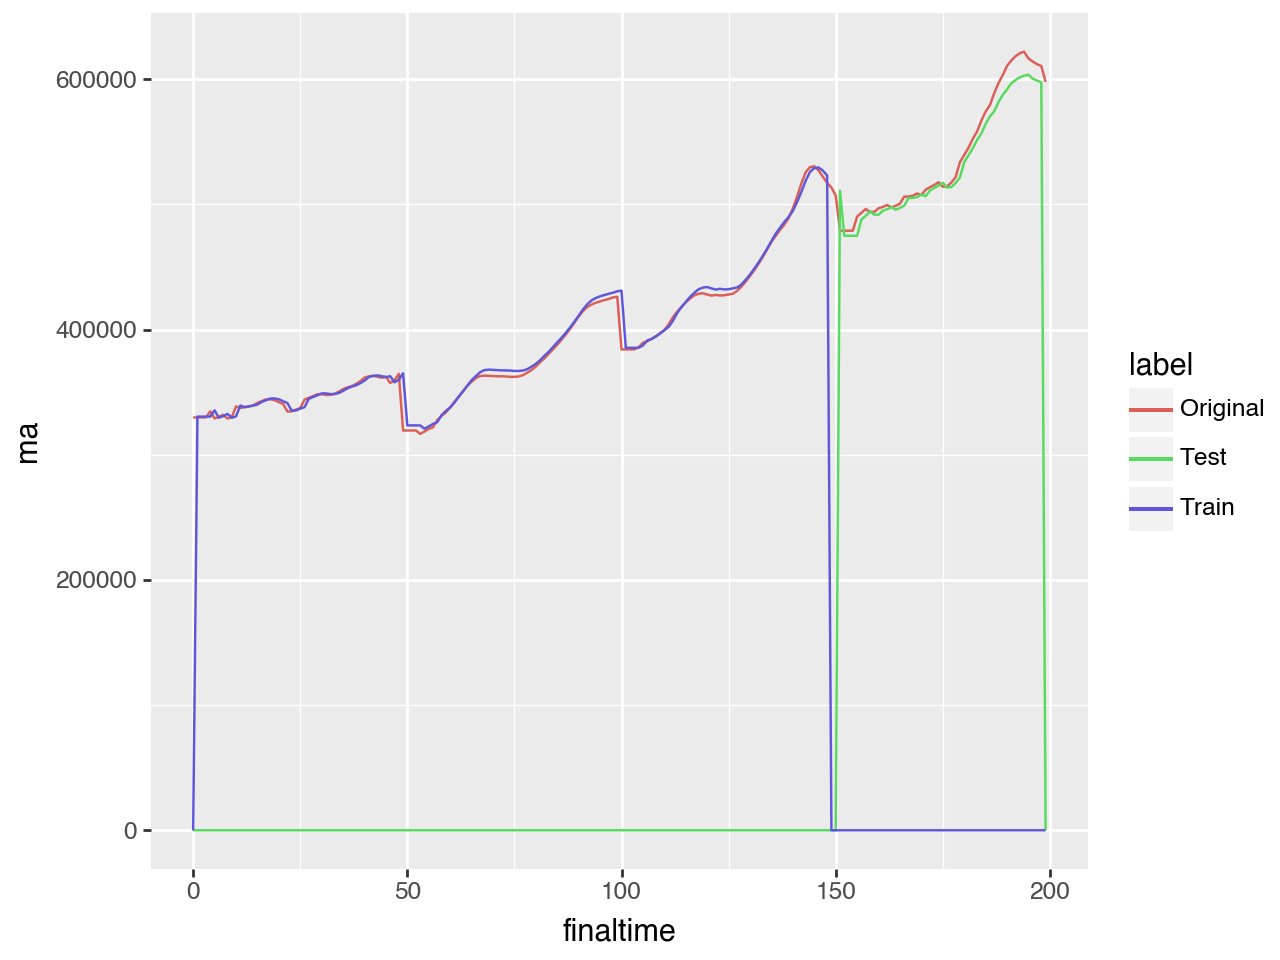

In [43]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(house_data2)
#trainPredictPlot[:, :] = np.nan
trainPredictPlot[:, :] = 0
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = np.empty_like(house_data2)
#testPredictPlot[:, :] = np.nan
testPredictPlot[:, :] = 0
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(house_data2)-1, :] = testPredict
# plot baseline and predictions
# plt.plot(scaler.inverse_transform(house_data2))
# plt.plot(trainPredictPlot)
# plt.plot(testPredictPlot)
# plt.show()


finalma = np.append(scaler.inverse_transform(house_data2)[:,0].flatten(), trainPredictPlot[:,0].flatten())
finalma = np.append(finalma, testPredictPlot[:,0].flatten())

finallabels = np.append(["Original"]*len(trainPredictPlot), ["Train"]*len(trainPredictPlot))
finallabels = np.append(finallabels, ["Test"]*len(testPredictPlot))

finaltime = np.append(range(len(trainPredictPlot)), range(len(trainPredictPlot)))
finaltime = np.append(finaltime, range(len(testPredictPlot)))

results = pd.DataFrame(data =
    {'timeindex': finaltime,
    'ma': finalma,
    'label': finallabels}
)

(ggplot(results, aes("finaltime", "ma", color = "label"))
 + geom_line())


This model with 75% train test split and a step back history of 1 has the lowest Test Score RMSE of 10586.79 

# Analyzing Only Units

### 80% Training Test Split with 2 Step History

In [14]:
units = house_data[house_data['type'] == 'unit']
unit_data2 = units
unit_data2 = unit_data2.drop(["saledate","type"], axis = 1)

# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
unit_data2 = scaler.fit_transform(unit_data2)

train_size = int(len(unit_data2) * 0.8)
test_size = len(unit_data2) - train_size
train, test = unit_data2[0:train_size], unit_data2[train_size:len(unit_data2)]
print(len(train), len(test))

117 30
117 30


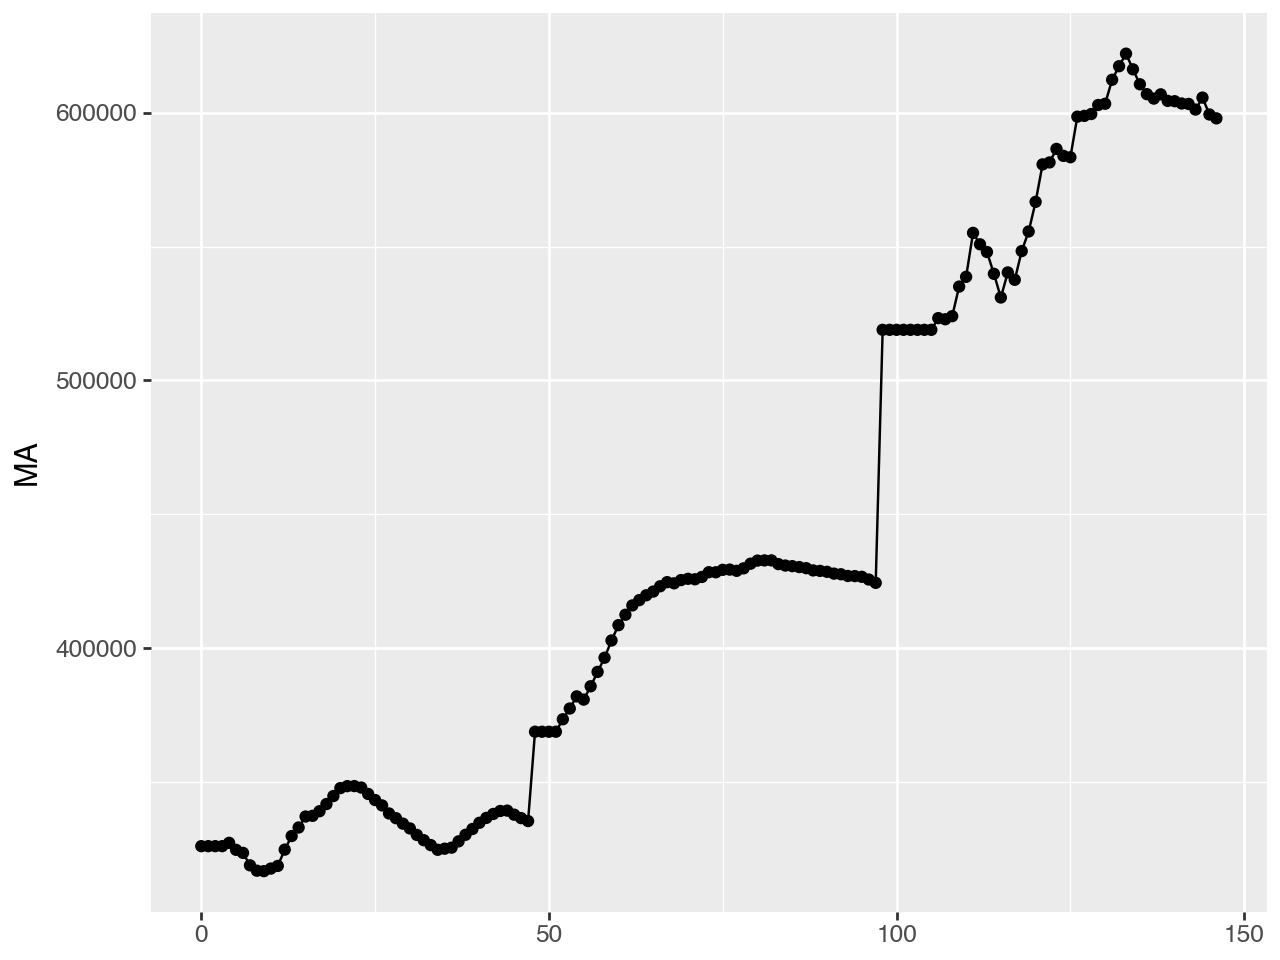

In [15]:
(ggplot(units, aes(range(len(units)), "MA"))
 + geom_point()
 + geom_line())

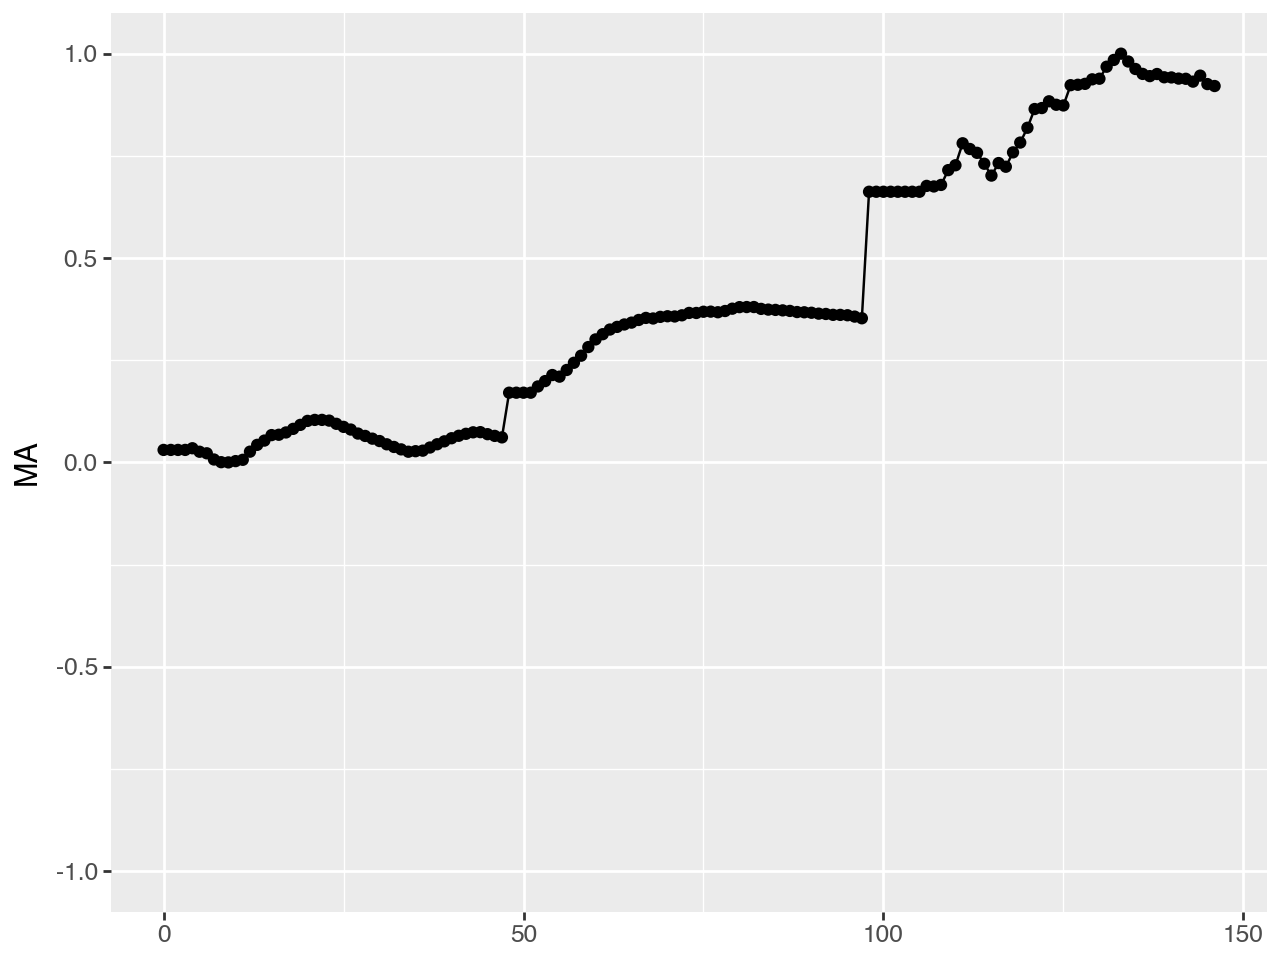

In [16]:
unit_data3 = pd.DataFrame(unit_data2)
unit_data3.columns = ["MA", "bedrooms"]
(ggplot(unit_data3, aes(range(len(unit_data3)), "MA"))
 + geom_point()
 + geom_line()
 + ylim(-1, 1))

In [17]:
# reshape into X=t and Y=t+1
look_back = 2
trainX, trainY = create_dataset_vars(train, look_back)
testX, testY = create_dataset_vars(test, look_back)

trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]*trainX.shape[2]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]*testX.shape[2]))


In [18]:
# create and fit the LSTM network
model = Sequential()
model.add(SimpleRNN(4, input_shape=(1, look_back*train.shape[1])))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=0)

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.


In [19]:
# Make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

# Add one dummy column 
trainPredict = np.hstack([trainPredict, np.zeros((trainPredict.shape[0], 1))])
testPredict = np.hstack([testPredict, np.zeros((testPredict.shape[0], 1))])

# Invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
testPredict = scaler.inverse_transform(testPredict)

# Prepare actual Y values with one dummy column
trainY2 = np.hstack([trainY.reshape(-1, 1), np.zeros((len(trainY), 1))])
testY2 = np.hstack([testY.reshape(-1, 1), np.zeros((len(testY), 1))])

# Invert actual Y values
trainY2 = scaler.inverse_transform(trainY2)
testY2 = scaler.inverse_transform(testY2)

# Calculate and print RMSE
trainScore = np.sqrt(mean_squared_error(trainY2[:, 0], trainPredict[:, 0]))
print('Train Score: %.2f RMSE' % trainScore)

testScore = np.sqrt(mean_squared_error(testY2[:, 0], testPredict[:, 0]))
print('Test Score: %.2f RMSE' % testScore)


1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


Train Score: 10435.64 RMSE
Test Score: 15173.72 RMSE
Train Score: 10435.64 RMSE
Test Score: 15173.72 RMSE


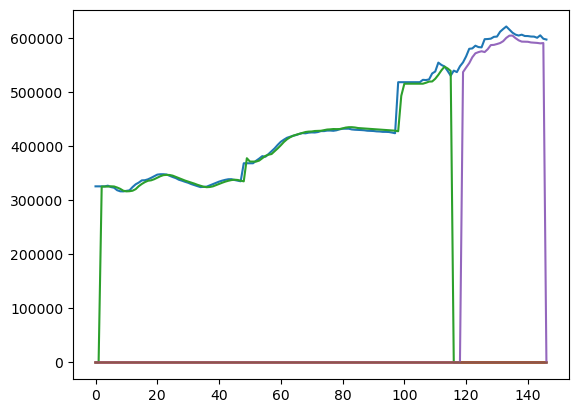

In [20]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(unit_data2)
#trainPredictPlot[:, :] = np.nan
trainPredictPlot[:, :] = 0
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = np.empty_like(unit_data2)
#testPredictPlot[:, :] = np.nan
testPredictPlot[:, :] = 0
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(unit_data2)-1, :] = testPredict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(unit_data2))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

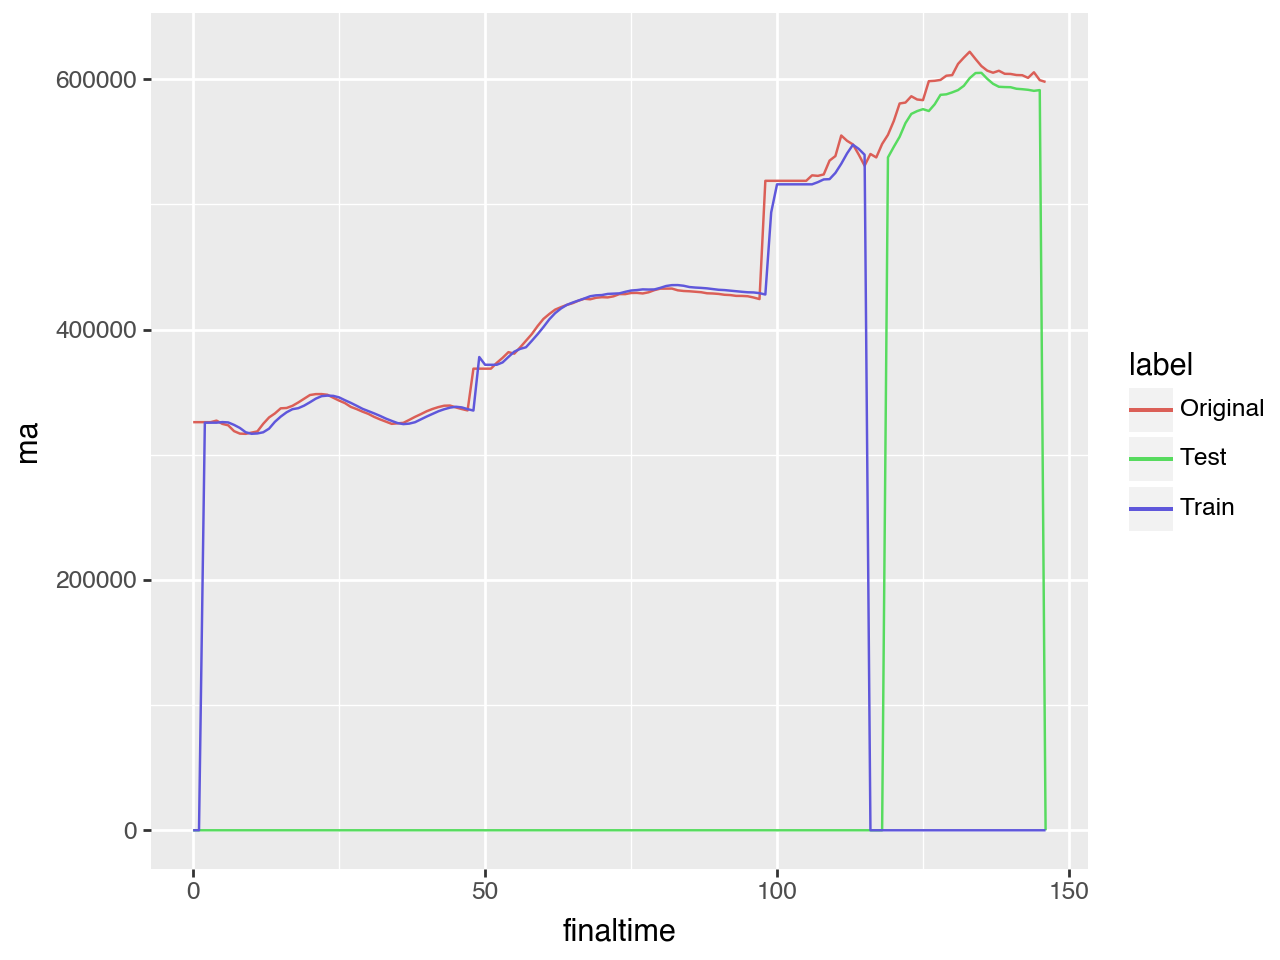

In [24]:
finalma = np.append(scaler.inverse_transform(unit_data2)[:,0].flatten(), trainPredictPlot[:,0].flatten())
finalma = np.append(finalma, testPredictPlot[:,0].flatten())

finallabels = np.append(["Original"]*len(trainPredictPlot), ["Train"]*len(trainPredictPlot))
finallabels = np.append(finallabels, ["Test"]*len(testPredictPlot))

finaltime = np.append(range(len(trainPredictPlot)), range(len(trainPredictPlot)))
finaltime = np.append(finaltime, range(len(testPredictPlot)))

results = pd.DataFrame(data =
    {'timeindex': finaltime,
    'ma': finalma,
    'label': finallabels}
)

(ggplot(results, aes("finaltime", "ma", color = "label"))
 + geom_line())


### Training Test Split of 90% and Step Back History of 3

In [44]:
train_size = int(len(unit_data2) * 0.9)
test_size = len(unit_data2) - train_size
train, test = unit_data2[0:train_size], unit_data2[train_size:len(unit_data2)]
print(len(train), len(test))

132 15
132 15


In [45]:
# reshape into X=t and Y=t+1
look_back = 3
trainX, trainY = create_dataset_vars(train, look_back)
testX, testY = create_dataset_vars(test, look_back)

trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]*trainX.shape[2]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]*testX.shape[2]))


In [46]:
# create and fit the LSTM network
model = Sequential()
model.add(SimpleRNN(4, input_shape=(1, look_back*train.shape[1])))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=0)

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.


In [47]:
# Make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

# Add one dummy column 
trainPredict = np.hstack([trainPredict, np.zeros((trainPredict.shape[0], 1))])
testPredict = np.hstack([testPredict, np.zeros((testPredict.shape[0], 1))])

# Invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
testPredict = scaler.inverse_transform(testPredict)

# Prepare actual Y values with one dummy column
trainY2 = np.hstack([trainY.reshape(-1, 1), np.zeros((len(trainY), 1))])
testY2 = np.hstack([testY.reshape(-1, 1), np.zeros((len(testY), 1))])

# Invert actual Y values
trainY2 = scaler.inverse_transform(trainY2)
testY2 = scaler.inverse_transform(testY2)

# Calculate and print RMSE
trainScore = np.sqrt(mean_squared_error(trainY2[:, 0], trainPredict[:, 0]))
print('Train Score: %.2f RMSE' % trainScore)

testScore = np.sqrt(mean_squared_error(testY2[:, 0], testPredict[:, 0]))
print('Test Score: %.2f RMSE' % testScore)


1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Train Score: 10509.30 RMSE
Test Score: 2601.35 RMSE
Train Score: 10509.30 RMSE
Test Score: 2601.35 RMSE


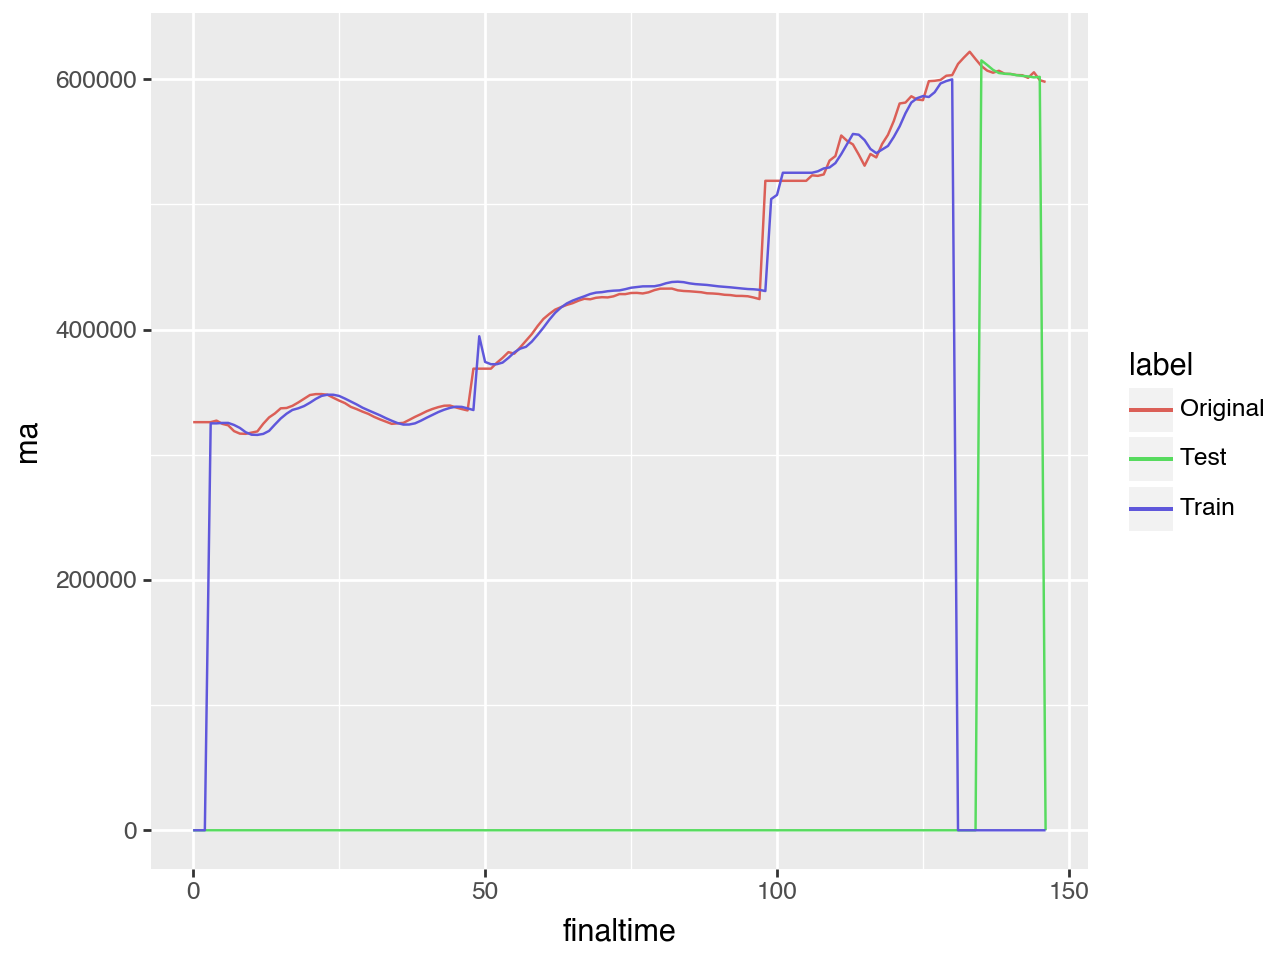

In [49]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(unit_data2)
#trainPredictPlot[:, :] = np.nan
trainPredictPlot[:, :] = 0
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = np.empty_like(unit_data2)
#testPredictPlot[:, :] = np.nan
testPredictPlot[:, :] = 0
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(unit_data2)-1, :] = testPredict
# plot baseline and predictions
# plt.plot(scaler.inverse_transform(unit_data2))
# plt.plot(trainPredictPlot)
# plt.plot(testPredictPlot)
# plt.show()

finalma = np.append(scaler.inverse_transform(unit_data2)[:,0].flatten(), trainPredictPlot[:,0].flatten())
finalma = np.append(finalma, testPredictPlot[:,0].flatten())

finallabels = np.append(["Original"]*len(trainPredictPlot), ["Train"]*len(trainPredictPlot))
finallabels = np.append(finallabels, ["Test"]*len(testPredictPlot))

finaltime = np.append(range(len(trainPredictPlot)), range(len(trainPredictPlot)))
finaltime = np.append(finaltime, range(len(testPredictPlot)))

results = pd.DataFrame(data =
    {'timeindex': finaltime,
    'ma': finalma,
    'label': finallabels}
)

(ggplot(results, aes("finaltime", "ma", color = "label"))
 + geom_line())

### Training Test Split of 75% and a Step Back History of 1

In [50]:
train_size = int(len(unit_data2) * 0.75)
test_size = len(unit_data2) - train_size
train, test = unit_data2[0:train_size], unit_data2[train_size:len(unit_data2)]
print(len(train), len(test))

110 37
110 37


In [51]:
# reshape into X=t and Y=t+1
look_back = 1
trainX, trainY = create_dataset_vars(train, look_back)
testX, testY = create_dataset_vars(test, look_back)

trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]*trainX.shape[2]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]*testX.shape[2]))


In [52]:
# create and fit the LSTM network
model = Sequential()
model.add(SimpleRNN(4, input_shape=(1, look_back*train.shape[1])))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=0)

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.


In [53]:
# Make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

# Add one dummy column 
trainPredict = np.hstack([trainPredict, np.zeros((trainPredict.shape[0], 1))])
testPredict = np.hstack([testPredict, np.zeros((testPredict.shape[0], 1))])

# Invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
testPredict = scaler.inverse_transform(testPredict)

# Prepare actual Y values with one dummy column
trainY2 = np.hstack([trainY.reshape(-1, 1), np.zeros((len(trainY), 1))])
testY2 = np.hstack([testY.reshape(-1, 1), np.zeros((len(testY), 1))])

# Invert actual Y values
trainY2 = scaler.inverse_transform(trainY2)
testY2 = scaler.inverse_transform(testY2)

# Calculate and print RMSE
trainScore = np.sqrt(mean_squared_error(trainY2[:, 0], trainPredict[:, 0]))
print('Train Score: %.2f RMSE' % trainScore)

testScore = np.sqrt(mean_squared_error(testY2[:, 0], testPredict[:, 0]))
print('Test Score: %.2f RMSE' % testScore)


1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


Train Score: 9843.46 RMSE
Test Score: 17728.03 RMSE
Train Score: 9843.46 RMSE
Test Score: 17728.03 RMSE


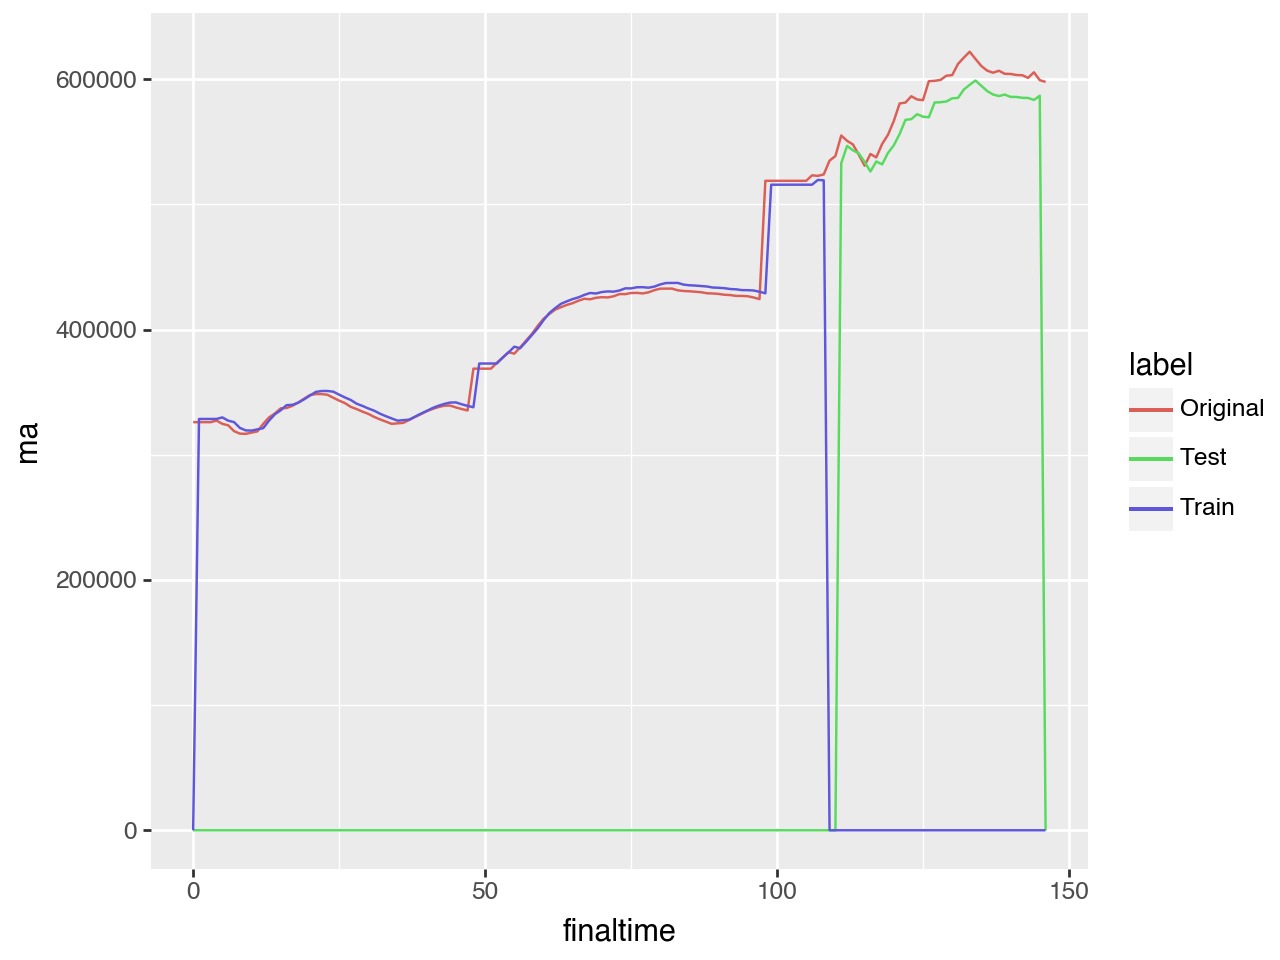

In [54]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(unit_data2)
#trainPredictPlot[:, :] = np.nan
trainPredictPlot[:, :] = 0
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = np.empty_like(unit_data2)
#testPredictPlot[:, :] = np.nan
testPredictPlot[:, :] = 0
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(unit_data2)-1, :] = testPredict
# plot baseline and predictions
# plt.plot(scaler.inverse_transform(unit_data2))
# plt.plot(trainPredictPlot)
# plt.plot(testPredictPlot)
# plt.show()

finalma = np.append(scaler.inverse_transform(unit_data2)[:,0].flatten(), trainPredictPlot[:,0].flatten())
finalma = np.append(finalma, testPredictPlot[:,0].flatten())

finallabels = np.append(["Original"]*len(trainPredictPlot), ["Train"]*len(trainPredictPlot))
finallabels = np.append(finallabels, ["Test"]*len(testPredictPlot))

finaltime = np.append(range(len(trainPredictPlot)), range(len(trainPredictPlot)))
finaltime = np.append(finaltime, range(len(testPredictPlot)))

results = pd.DataFrame(data =
    {'timeindex': finaltime,
    'ma': finalma,
    'label': finallabels}
)

(ggplot(results, aes("finaltime", "ma", color = "label"))
 + geom_line())

The model with a 90% train test split and a step back history of 3 had the lowest Test Score RMSE of 2601.35.
